# A brief recap about DL Pipeline

- Define the task
  - Frame the problem
  - Collect a dataset
  - Understand your data
  - Choose a measure of success
- Develop a model
  - Prepare the data
  - Choose an evaluation protocol
  - Beat a baseline
  - Scale up: develop a model that overfits
  - Regularize and tune your model
- Deploy your model
  - Explain your work to stakeholders and set expectations
    - Ship an inference model
    - Deploying a model as a rest API
    - Deploying a model on device
    - Deploying a model in the browser
  - Monitor your model in the wild
  - Maintain your model


# 1.0 Baseline Model

## 1.1 Import Libraries

Install and import the Keras Tuner.

In [ ]:
# pip install -q (quiet)
!pip install git+https://github.com/keras-team/keras-tuner.git -q

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import datetime
import pytz
import IPython
import kerastuner as kt

In [ ]:
print('TF version:', tf.__version__)
print('KT version:', kt.__version__)
print('GPU devices:', tf.config.list_physical_devices('GPU'))

TF version: 2.4.1
KT version: 1.0.3
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1.2 Utils Functions

In [ ]:
def load_dataset():
    # load the train data
    train_dataset = h5py.File('train_catvnoncat.h5', "r")

    # your train set features
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) 

    # your train set labels
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 

    # load the test data
    test_dataset = h5py.File('test_catvnoncat.h5', "r")

    # your test set features
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 

    # your test set labels  
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 

    # the list of classes
    classes = np.array(test_dataset["list_classes"][:]) 

    # reshape the test data
    train_set_y_orig = train_set_y_orig.reshape((train_set_y_orig.shape[0],1))
    test_set_y_orig = test_set_y_orig.reshape((test_set_y_orig.shape[0],1))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## 1.3 Load Dataset

In [ ]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_y, test_set_x_orig, test_y, classes = load_dataset()

In [ ]:
# Reshape the training and test examples
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1)
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1)

# Standardize the dataset
train_x = train_set_x_flatten/255
test_x = test_set_x_flatten/255

In [ ]:
print ("train_x shape: " + str(train_x.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x  shape: " + str(test_x.shape))
print ("test_y  shape: " + str(test_y.shape))

train_x shape: (209, 12288)
train_y shape: (209, 1)
test_x  shape: (50, 12288)
test_y  shape: (50, 1)


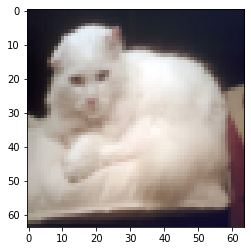

In [ ]:
# visualize a sample data
index = 13
plt.imshow(train_set_x_orig[index])

## 1.4 Model

In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):

  def on_train_begin(self, batch, logs=None):
    self.begins = time.time()
    print('Training: begins at {}'.format(datetime.datetime.now(pytz.timezone('America/Fortaleza')).strftime("%a, %d %b %Y %H:%M:%S")))

  def on_train_end(self, logs=None):
    print('Training: ends at {}'.format(datetime.datetime.now(pytz.timezone('America/Fortaleza')).strftime("%a, %d %b %Y %H:%M:%S")))
    print('Duration: {:.2f} seconds'.format(time.time() - self.begins))    

In [ ]:
# Instantiate a simple classification model
model = tf.keras.Sequential([
  tf.keras.layers.Dense(8, activation=tf.nn.relu, dtype='float64'),
  tf.keras.layers.Dense(8, activation=tf.nn.relu, dtype='float64'),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, dtype='float64')
])

# Instantiate a logistic loss function that expects integer targets.
loss = tf.keras.losses.BinaryCrossentropy()

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.BinaryAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history = model.fit(x=train_x,
                    y=train_y,
                    batch_size=32,
                    epochs=500,
                    validation_data=(test_x,test_y),
                    callbacks=[MyCustomCallback()],
                    verbose=1)

In [ ]:
loss, acc = model.evaluate(x=train_x,y=train_y, batch_size=32)
print('Train loss: %.4f - acc: %.4f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
print('Test loss: %.4f - acc: %.4f' % (loss_, acc_))

7/7 [==============================] - 0s 3ms/step - loss: 0.0727 - binary_accuracy: 1.0000
Train loss: 0.0727 - acc: 1.0000
2/2 [==============================] - 0s 5ms/step - loss: 0.7523 - binary_accuracy: 0.7400
Test loss: 0.7523 - acc: 0.7400


# 2.0 Hyperparameter Tuning using Keras-Tuner

The [Keras Tuner](https://github.com/keras-team/keras-tuner) is a library that helps you pick the optimal set of hyperparameters for your TensorFlow program. The process of selecting the right set of hyperparameters for your machine learning (ML) application is called **hyperparameter tuning** or **hypertuning**. 

Hyperparameters are the variables that govern the training process and the topology of an ML model. These variables remain constant over the training process and directly impact the performance of your ML program. Hyperparameters are of two types:
1. **Model hyperparameters** which influence model selection such as the number and width of hidden layers
2. **Algorithm hyperparameters** which influence the speed and quality of the learning algorithm such as the learning rate for Stochastic Gradient Descent (SGD) and the number of nearest neighbors for a k Nearest Neighbors (KNN) classifier, among others.


## 2.1 Define the model



When you build a model for hypertuning, you also define the hyperparameter search space in addition to the model architecture. The model you set up for hypertuning is called a **hypermodel**.

You can define a hypermodel through two approaches:

* By using a model builder function
* By subclassing the `HyperModel` class of the Keras Tuner API

You can also use two pre-defined `HyperModel` classes - [HyperXception](https://keras-team.github.io/keras-tuner/documentation/hypermodels/#hyperxception-class) and [HyperResNet](https://keras-team.github.io/keras-tuner/documentation/hypermodels/#hyperresnet-class) for computer vision applications.

In this section, you use a model builder function to define the image classification model. The model builder function returns a compiled model and uses hyperparameters you define inline to hypertune the model.

In [ ]:
def model_builder(hp):
  # Instantiate a simple classification model
  model = tf.keras.Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 8-32
  hp_units = hp.Int('units', min_value = 8, max_value = 32, step = 8)
  model.add(tf.keras.layers.Dense(hp_units, activation=tf.nn.relu, dtype='float64'))
  model.add(tf.keras.layers.Dense(8, activation=tf.nn.relu, dtype='float64'))
  model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, dtype='float64'))

  # Instantiate a logistic loss function that expects integer targets.
  loss = tf.keras.losses.BinaryCrossentropy()

  # Instantiate an accuracy metric.
  accuracy = tf.keras.metrics.BinaryAccuracy()

  # Instantiate an optimizer.
  optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

  # configure the optimizer, loss, and metrics to monitor.
  model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

  return model

## 2.2 Instantiate the tuner and perform hypertuning



Instantiate the tuner to perform the hypertuning. The Keras Tuner has [four tuners available](https://keras-team.github.io/keras-tuner/documentation/tuners/) - `RandomSearch`, `Hyperband`, `BayesianOptimization`, and `Sklearn`. 

Notice that in previous subsection we're not fitting there, and we're returning the compiled model. Let's continue to build out the rest of our program first, then we'll make things more dynamic. Adding the dynamic bits will all happen in the **model_builder** function, but we will need some other code that will use this function now.  To start, we're going to import **RandomSearch** and after that we'll first define our tuner.

In [ ]:
from kerastuner.tuners import RandomSearch

In [ ]:
# path to store results
LOG_DIR = f"{int(time.time())}"

In [ ]:
tuner = RandomSearch(model_builder,
                     objective='val_binary_accuracy',
                     max_trials=4,  # how many model configurations would you like to test?
                     executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
                     directory=LOG_DIR,
                     project_name="my_first_tuner"
                     )

- Your objective here probably should be **validation accuracy**, but you can choose from other things like **val_loss** for example.
- **max_trials** allows you limit how many tests will be run. If you put 10 here, you will get 10 different tests (provided you've specified enough variability for 10 different combinations, anyway).
- **executions_per_trial** might be 1, but you might also do many more like 3,5, or even 10.

Basically, if you're just hunting for a model that works, then you should just do 1 trial per variation. If you're attempting to seek out 1-3% on **validation accuracy**, then you should run 3+ trials most likely per model, because each time a model runs, you should see some variation in final values. So this will just depend on what kind of a search you're doing (just trying to find something that works vs fine tuning...or anything in between).

Run the hyperparameter search. The arguments for the search method are the same as those used for [`tf.keras.model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit).

Before running the hyperparameter search, define a callback to clear the training outputs at the end of every training step.

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
tuner.search(train_x,
             train_y, 
             epochs = 500, 
             verbose=1,
             batch_size=32,
             validation_data = (test_x, test_y),
             callbacks = [ClearTrainingOutput()])

Trial 4 Complete [00h 00m 37s]
val_binary_accuracy: 0.800000011920929

Best val_binary_accuracy So Far: 0.800000011920929
Total elapsed time: 00h 02m 29s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# print a summary of results
tuner.results_summary(num_trials=10)

Results summary
Results in 1615218175/my_first_tuner
Showing 10 best trials
Objective(name='val_binary_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 16
Score: 0.800000011920929
Trial summary
Hyperparameters:
units: 32
Score: 0.7799999713897705
Trial summary
Hyperparameters:
units: 24
Score: 0.7599999904632568
Trial summary
Hyperparameters:
units: 8
Score: 0.7400000095367432


In [ ]:
# best hyperparameters is a dictionary
tuner.get_best_hyperparameters()[0].values

{'units': 16}

In [ ]:
# search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 1
units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 32, 'step': 8, 'sampling': None}


In [ ]:
print(f"""The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {tuner.get_best_hyperparameters()[0].values.get('units')}""")

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 16


## 2.3 Playing with search space

We also can play with the search space in order to contain conditional hyperparameters. Below, we have a **for loop** creating a **tunable number of layers**, which themselves involve a tunable **units** parameter. This can be pushed to any level of parameter interdependency, including recursion. Note that all parameter names should be unique (here, in the loop over **i**, we name the inner parameters **'units_'** + **str(i)**).

In [ ]:
def model_builder_all(hp):
  # Instantiate a simple classification model
  model = tf.keras.Sequential()
  
  # Create a tunable number of layers 1,2,3,4
  for i in range(hp.Int('num_layers', 1, 4)):

    # Tune the number of units in the Dense layer
    # Choose an optimal value between 8-32
    model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                        min_value = 8,
                                        max_value = 32,
                                        step = 8),
                                    # Tune the activation functions
                                    activation= hp.Choice('dense_activation_' + str(i),
                                                          values=['relu', 'tanh'],
                                                          default='relu'),
                                    dtype='float64'))

  model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, dtype='float64'))

  # Instantiate a logistic loss function that expects integer targets.
  loss = tf.keras.losses.BinaryCrossentropy()

  # Instantiate an accuracy metric.
  accuracy = tf.keras.metrics.BinaryAccuracy()

  optimizer = hp.Choice('optimizer', ['adam', 'SGD'])
  if optimizer == 'adam':
    opt = tf.keras.optimizers.Adam(learning_rate=hp.Float('lrate_adam',
                                                          min_value=1e-4,
                                                          max_value=1e-2, 
                                                          sampling='LOG'))
  else:
    opt = tf.keras.optimizers.SGD(learning_rate=hp.Float('lrate_sgd',
                                                          min_value=1e-4,
                                                          max_value=1e-2, 
                                                          sampling='LOG'))

  # configure the optimizer, loss, and metrics to monitor.
  model.compile(optimizer=opt, loss=loss, metrics=[accuracy])

  return model

In [ ]:
# path to store results
LOG_DIR = f"{int(time.time())}"

In [ ]:
tuner_ = RandomSearch(model_builder_all,
                     objective='val_binary_accuracy',
                     max_trials=20,  # how many model configurations would you like to test?
                     executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
                     directory=LOG_DIR,
                     project_name="my_first_tuner"
                     )

In [ ]:
tuner_.search(train_x,
             train_y, 
             epochs = 500,
             # verbose = 0 (silent) 
             verbose=0,
             batch_size=32,
             validation_data = (test_x, test_y),
             callbacks = [ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner_.results_summary()

In [ ]:
tuner_.get_best_hyperparameters()[0].values

{'dense_activation_0': 'relu',
 'dense_activation_1': 'relu',
 'dense_activation_2': 'relu',
 'dense_activation_3': 'relu',
 'lrate_adam': 0.0002686497617348805,
 'lrate_sgd': 0.009387416394597664,
 'num_layers': 3,
 'optimizer': 'SGD',
 'units_0': 8,
 'units_1': 16,
 'units_2': 16,
 'units_3': 32}

In [ ]:
tuner_.search_space_summary()

## 2.4 Retrain the model with the optimal hyperparameters

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data
best_hps = tuner_.get_best_hyperparameters()[0]
model = tuner_.hypermodel.build(best_hps)
model.fit(train_x, train_y, epochs = 500, validation_data = (test_x, test_y),batch_size=32)

In [ ]:
loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

2/2 [==============================] - 0s 5ms/step - loss: 2.0225 - binary_accuracy: 0.6800
Test loss: 2.022 - acc: 0.680


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 98312     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 98,745
Trainable params: 98,745
Non-trainable params: 0
_________________________________________________________________


<mark>Exercise</mark>

Hyperparameter tuning is a time-consuming task. The previous result was not so good. You can try to improve it the tuning considering:
- Other [Tuners](https://keras-team.github.io/keras-tuner/documentation/tuners/): BayesianOptimization, Hyperband
- Evaluate **max_trials** ranges over 100 or more?
- **executions_per_trial** values in [2,3]?
- How about you write an article on Medium about Keras Tuner?

In [ ]:
# PUT YOUR CODE HERE

# 3.0 References

1. https://www.kaggle.com/fchollet/moa-keras-kerastuner-best-practices/
2. https://www.kaggle.com/fchollet/titanic-keras-kerastuner-best-practices
3. https://www.kaggle.com/fchollet/keras-kerastuner-best-practices
4. https://pythonprogramming.net/keras-tuner-optimizing-neural-network-tutorial/
5. https://github.com/keras-team/keras-tuner
6. https://machinelearningmastery.com/autokeras-for-classification-and-regression/